# Contextual Bandits with Parametric Actions -- Experimentation Mode

We demonstrate how you can use varying number of actions with contextual bandits algorithms in SageMaker. This notebook builds on 
the [Contextual Bandits example notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/reinforcement_learning/bandits_statlog_vw_customEnv/bandits_statlog_vw_customEnv.ipynb) example notebook which used fixed number of actions. Please refer to that notebook for basics on contextual 
bandits. 

In the contextual bandit setting, an agent recommends an action given a state. This notebook introduces three features to bandit algorithms that make them applicable to a broader set of real-world problems. We use the movie recommendation problem as an example.
1. The number of actions available to the agent can change over time. For example, the movies in the catalog changes over time.
2. Each action may have features associated with it. For the movie recommendation problem, each movie can have features such as 
genre, cast, etc.
3. The agent can produce a ranked list of actions/items. When recommending movies, it is natural that multiple movies are recommended at a time step.

The contextual bandit agent will trade-off between exploitation and exploration to quickly learn user preferences and minimize 
poor recommendations. The bandit algorithms are appropriate to use in recommendation problems when there are many cold items (items which have no or little interaction data) in the catalog or if user preferences change over time.

### What is Experimentation Mode?

Contextual bandits are often used to train models by interacting with the real world. In movie recommendation, the bandit learns user preferences based on their feedback from past interactions. To test if bandit algorithms are applicable for your use case, you may want to test different algorithms and understand the impact of different features, hyper-parameters. Experimenting with real users can lead to poor experience due to unanticipated issues or poor performance. Experimenting in production comes with the complexity of working with infrastructure components (e.g. web services, data engines, databases) designed for scale. With Experimentation Mode, you can get started with a small dataset or a simulator and identify the algorithm, features and hyper-parameters that are best applicable for your use case. The experimentation is much faster, does not impact real users and easy to work with. Once you are satisfied with the algorithm performance, you can switch to [Deployment Mode](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/reinforcement_learning/bandits_statlog_vw_customEnv/bandits_statlog_vw_customEnv.ipynb), where we provide infrastructure support that scales to production requirements.

<p align="center">
    <img src="workflow.png">
</p>

## Pre-requisites 

### Imports

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import json
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import time
from time import gmtime, strftime
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator
%matplotlib inline

### Setup S3 bucket

Set up the linkage and authentication to the S3 bucket that you want to use for data and model outputs.

In [2]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-us-east-1-835319576252/


In [3]:
# Check AWS Region
aws_region = sage_session.boto_region_name
#if aws_region not in ["us-west-2"]:
#    raise Exception(
#    """
#    This notebook can currently run only in us-west-2. Support for other regions
#    will be added soon.
#    """)            

### Configure where training happens

You can run this notebook on a `SageMaker notebook instance` or on your own machine. In both of these scenarios, you can do the training/inference in either the local or the SageMaker mode. The local mode uses the SageMaker Python SDK to run your code in a docker container locally. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set local_mode = True.  

If local mode is `False`, then training/inference runs on a SageMaker machine.

In [4]:
# run in local mode?
local_mode = True

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.c5.2xlarge"

### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::835319576252:role/service-role/AmazonSageMaker-ExecutionRole-20191006T135881


### Simulation environment (from MovieLens data)
The simulation environment `src/env.py` simulates a live environment that can interact with the SageMaker bandits training to produce a recommender agent (or policy). The logic of reward generation resides in simulator itself. We simulate the online learning loop with feedback using this environment inside the training job itself. The simulator uses MovieLens 100k dataset.

The training workflow is as follows:
- **User sampling and candidate list generation**: The simulator picks a user u and a list of 100 items (defined by `item_pool_size`) at random, which is sent to the SageMaker agent for retrieving recommendations. This list consists of the movies that the user u has rated in the past, as we know the true user preferences (ratings) for these movies. In this simulator, we use `user_id` to identify the user and represent each movie using the genre features.
- **Bandit Slate recommendation**: SageMaker bandit agent returns a recommendation - a list of top-k items.
- **Feedback generation by simulating user behaviour**: The reward is given to the agent based on user ratings in the dataset. We assume a Cascade Click model, where the user scans the list top-down, and clicks on the item that she likes. We give a reward of 0 to all the items above the clicked item and a reward to 1 to the item that was clicked. No feedback is generated for the items below the clicked item.
- **Feedback ingestion**: The corresponding rewards and the actions are reported to the agent for learning.

The training job uses the files in the `src` folder. The descriptions of the important files are as follows:
- `src/train.py` - This is the entrypoint for the training job. This file contains the main logic for training:
    - It initializes a bandit agent.
    - Starts an interaction loop in which the agent interacts with the envrionment, recommends some actions, ingests the feedback and improves over time.
    - The agent is saved on S3 after training finishes and can be used later for inference.
- `src/env.py` - This file implements the simulation environment using MovieLens 100K dataset. It also contains the logic for reward generation using the Cascade Click model.
- `src/vw_agent.py` - This implements a bandit agent interface in python that communicates with a VW C++ process at the backend.

#### MovieLens 100K usage license
Please be aware of the following requirements regarding acknowledgment, copyright and availability, cited from the [data set description page](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

The data set may be used for any research purposes under the following conditions:

 * The user may not state or imply any endorsement from the
   University of Minnesota or the GroupLens Research Group.
 * The user must acknowledge the use of the data set in
   publications resulting from the use of the data set
   (see below for citation information).
 * The user may not redistribute the data without separate
   permission.
 * The user may not use this information for any commercial or
   revenue-bearing purposes without first obtaining permission
   from a faculty member of the GroupLens Research Project at the
   University of Minnesota.
   
If you have any further questions or comments, please contact GroupLens (grouplens-info@cs.umn.edu).

#### Download MovieLens 100K and upload to S3

In [6]:
%%bash
curl -o ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip
unzip -o ml-100k.zip

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  10.8M      0 --:--:-- --:--:-- --:--:-- 10.8M


In [7]:
movielens_data_s3_path = sage_session.upload_data(path="ml-100k", bucket=s3_bucket, key_prefix="movielens/data")

## Train the Bandit model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance/your local machine. When using SageMaker for training, you can select a CPU instance. The RLEstimator is used for training the bandit agent.

1. Specify the hyperparameters for the bandit algorithm and the environment configuration. 
2. Specify the source directory where the environment, training code and dependencies are present - `src` folder
3. Specify the training entrypoint - `train.py`
4. Specify the container image
5. Define the training parameters such as the instance count, job name, S3 path for output and job name.  
6. Specify the input dataset - `movielens_data_s3_path` in the `.fit` call

#### Define the hyperparameters and the training job name prefix

In [8]:
hyperparameters = {
                   # Algorithm params
                   "arm_features": True,
                   "exploration_policy": "regcbopt",
                   "mellowness": 0.01,
                   
                   # Env params
                   "item_pool_size": 100,
                   "top_k": 5,
                   "total_interactions": 2000,
                   "max_users": 100,
                   }

job_name_prefix = "testbed-bandits-1"

In [9]:
vw_image_repo = '462105765813.dkr.ecr.{}.amazonaws.com/sagemaker-rl-vw-container'.format(aws_region)
#vw_image_tag = 'adf'
vw_image_tag = 'vw-8.7.0-cpu'
vw_image_uri = '{}:{}'.format(vw_image_repo, vw_image_tag)
#vw_image_uri = '462105765813.dkr.ecr.{}.amazonaws.com/sagemaker-rl-vw-container:adf'.format(aws_region)

In [10]:
estimator = RLEstimator(entry_point='train.py',
                        source_dir='src',
                        image_name=vw_image_uri,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = hyperparameters
                    )

estimator.fit(inputs={"movielens": movielens_data_s3_path}, wait=True)

Creating tmpakj6l8od_algo-1-jz219_1 ... 
Attaching to tmpakj6l8od_algo-1-jz219_12mdone
algo-1-jz219_1  | 2020-08-12 19:19:38,889 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jz219_1  | 2020-08-12 19:19:38,902 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jz219_1  | 2020-08-12 19:19:38,913 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jz219_1  | 2020-08-12 19:19:38,923 sagemaker-containers INFO     Invoking user script
algo-1-jz219_1  | 
algo-1-jz219_1  | Training Env:
algo-1-jz219_1  | 
algo-1-jz219_1  | {
algo-1-jz219_1  |     "additional_framework_parameters": {
algo-1-jz219_1  |         "sagemaker_estimator": "RLEstimator"
algo-1-jz219_1  |     },
algo-1-jz219_1  |     "channel_input_dirs": {
algo-1-jz219_1  |         "movielens": "/opt/ml/input/data/movielens"
algo-1-jz219_1  |     },
algo-1-jz219_1  |     "current_host": "algo-1-jz219",
algo-1-jz219_1  |     "framewor

algo-1-jz219_1  | INFO:root:Processed 500 interactions
algo-1-jz219_1  | INFO:root:Processed 1000 interactions
algo-1-jz219_1  | INFO:root:Processed 1500 interactions
algo-1-jz219_1  | creating quadratic features for pairs: sd 
algo-1-jz219_1  | final_regressor = /opt/ml/model/vw.model
algo-1-jz219_1  | predictions = /dev/stdout
algo-1-jz219_1  | Num weight bits = 18
algo-1-jz219_1  | learning rate = 0.5
algo-1-jz219_1  | initial_t = 0
algo-1-jz219_1  | power_t = 0.5
algo-1-jz219_1  | using no cache
algo-1-jz219_1  | Reading datafile = 
algo-1-jz219_1  | num sources = 1
algo-1-jz219_1  | average  since         example        example  current  current  current
algo-1-jz219_1  | loss     last          counter         weight    label  predict features
algo-1-jz219_1  |     n.a.     n.a.            1            1.0  unknown        0:1...      320
algo-1-jz219_1  |     n.a.     n.a.            2            2.0  unknown        0:1...      315
algo-1-jz219_1  |     n.a.     n.a.            4 

===== Job Complete =====


#### Download the outputs to plot performance

Once the training is complete, we can download the regrets data to plot the performance of the bandit agent.

In [11]:
job_name = estimator.latest_training_job.job_name

SageMaker saves the model in `model.tar.gz` and other job output in `output.tar.gz`

In [12]:
if local_mode:
    output_path_prefix = f"{job_name}/output.tar.gz"
    model_path = f"{job_name}/model.tar.gz"
    
else:
    output_path_prefix = f"{job_name}/output/output.tar.gz"
    model_path = f"{job_name}/output/model.tar.gz"
    
sage_session.download_data(path="./output", bucket=s3_bucket, key_prefix=output_path_prefix)

In [13]:
%%bash
tar -C ./output -xvzf ./output/output.tar.gz

data/
data/output.json
intermediate/
intermediate/.tmp.sagemaker_s3_sync/
success


In [14]:
if local_mode:
    output_path_local = "output/data/output.json"
else:
    output_path_local = "output/output.json"

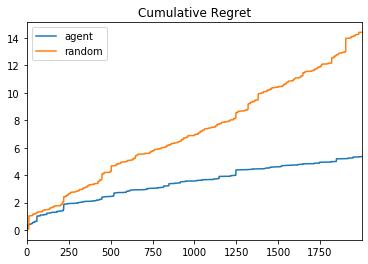

In [15]:
with open(output_path_local) as f:
    all_regrets = json.load(f)
    
all_regrets = {key: np.cumsum(val) for key,val in all_regrets.items()}
df = pd.DataFrame(all_regrets)
df.plot(title="Cumulative Regret")

Regret at a time step is defined as the difference between the optimal reward that an agent can get and the actual reward that the agent got. 

As can be seen from the above plot, the bandit agent leads to a much lesser cumulative regret compared to choosing the actions at random. If we run the training for a larger no. of interactions (`total_interactions`), we will observe that the cumulative regret curve flattens out, which means that the agent has learned the user preferences successfully and training has converged.

Now, let's see how we can use the trained model to perform inference on new data.

### Create a SageMaker model for inference

In [16]:
sage_session = sagemaker.local.LocalSession() if local_mode else sage_session

In [17]:
bandit_model = sagemaker.model.Model(image=vw_image_uri,
                                     role=role,
                                     name='vw-model-1',
                                     model_data=f's3://{s3_bucket}/{model_path}',
                                     sagemaker_session=sage_session)

In [18]:
bandit_model.deploy(initial_instance_count=1, 
                    instance_type=instance_type, 
                    endpoint_name='bandit')

!

In [19]:
predictor = sagemaker.predictor.RealTimePredictor(endpoint="bandit",
                                                  sagemaker_session=bandit_model.sagemaker_session,
                                                  serializer=sagemaker.predictor.json_serializer,
                                                  deserializer=sagemaker.predictor.json_deserializer,
                                                 )

In [20]:
predictor.predict({"shared_context": None, "actions_context": [[0, 0, 1], [1, 0, 0], [1, 1, 1]], "top_k": 2})

{'actions': [1, 0],
 'action_probs': [1.0, 1.0],
 'event_id': 267893825648137133171651117199010168834,
 'timestamp': 1597259988,
 'sample_prob': 0.17716832255614456,
 'model_id': 'default_model'}

### Clean Up endpoint

In [21]:
#if "predictor" in locals():
#predictor.delete_endpoint()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py", line 618, in run
    _stream_output(self.process)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py", line 677, in _stream_output
    raise RuntimeError("Process exited with code: %s" % exit_code)
RuntimeError: Process exited with code: 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sagemaker/local/image.py", line 623, in run
    raise RuntimeError(msg)
RuntimeError: Failed to run: ['docker-compose', '-f', '/tmp/tmpbll3x0fb/docker-compose.yaml', 'up', '--build', '--abort-on-container-exit'], Process exited with code: 1

